In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import calendar
import seaborn as sns
from scipy import stats
import folium
from folium import plugins
from mpl_toolkits.basemap import Basemap
from sklearn.impute import SimpleImputer
import researchpy as rp
from scipy.stats import ttest_ind
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn.preprocessing import scale
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
import statsmodels.api as sm

# Road Traffic Accident Severity
## An exploration of road traffic data from the UK
### By Anita K.

### Abstract

The purpose of this research is to gain an in-depth understanding of road traffic by examining and identifying the key variables affecting accidents and the complex relationships between them.<br>The research approach follows the scientific method in order to test a certain hypothesis, and breaks down every step of the data science process by providing explanations/comments alongside the code implementaton.<br>

The project is particularly suitable for beginners in the field of data science as it does not require extensive domain knowledge.


### Introduction and Data Acquisition

According to IBM, 80% of a data scientist’s valuable time is spent simply finding, cleansing, and organizing data, leaving only 20% to actually perform analysis.<br>
A crucial step of the process is identifying relevant data sets from reliable sources, which is no small task.<br>
Researching the topic at hand led to three datasets which were published by the British Department of Transport on an official open data government website.<br>
**The datasets being used in the project can be downloaded [here](http://data.dft.gov.uk.s3.amazonaws.com/road-accidents-safety-data/Stats19_Data_2005-2014.zip)**.
The supporting documentation files and their respective links are as follows:
- [Brief guide to road accidents and safety data](http://data.dft.gov.uk/road-accidents-safety-data/Brief-guide-to%20road-accidents-and-safety-data.doc)<br>
- [Lookup tables for variables](http://data.dft.gov.uk/road-accidents-safety-data/Road-Accident-Safety-Data-Guide.xls)<br>

### Framing the Problem
The main question that this research will try to tackle is whether specific road conditions are correlated with a higher degree of accident severity.<br>
The hypothesis testing will assume a p-value threshold of 0.01, which means that there is a 1% chance the observed results are coincidental.<br>
At the same time, during the data analysis we will also try to keep an eye out for any other interesting interrelationships between variables which may not have been obvious from the start.

**Previous Research**<br>
Similar research using various libraries and methodologies can be found on Kaggle. However, the datasets posted there appear to have been modified as compared to the original source. The major changes include: segmenting the full dataset, resulting in a missing year in the time series; incorrect values in certain columns and replacing the values of a number of categorical variables marked as integers with their string labels. Having this in mind, the present research will stick to the original data and refrain from any comparisons to avoid confusion.


### Data Tidying and Cleaning
Having obtained our data, it is now time to explore and prepare it for analysis.<br>
After inspecting the dataset documentation, we observe that there are a lot of missing values and all unknown data is marked as "-1". We will first convert all "-1" values to NaNs and then decide how to handle them on a column by column basis. We will not be dropping *all* of them because that would significantly reduce the size of all datasets.<br>
During the preliminary exploration, we observe a one-to-many relationship between the Traffic Data dataset, and the Vehicles and Casualties datasets which we will try to make use of later on.<br>Conveniently, there are geographic coordinates as well, so we will plot the accident locations using both basemap and folium.<br>

In [3]:
traffic_data = pd.read_csv("Accidents0514.csv", low_memory=False)
traffic_data = traffic_data.replace(-1, np.nan)

In [4]:
traffic_data.shape

(1640597, 32)

In case of computational constraints, one can work with a sample of the entire dataset.

In [119]:
# traffic_data_sample = traffic_data.iloc[:100000]

In [5]:
# traffic_data["Accident_Index"].is_unique

The Accident_Index column is randomly generated for administrative purposes, but we will keep it in order to be able to refer to the other datasets as described above.

In [6]:
# Expand the display panel to view all columns:

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
traffic_data.head()

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,Local_Authority_(District),Local_Authority_(Highway),1st_Road_Class,1st_Road_Number,Road_Type,Speed_limit,Junction_Detail,Junction_Control,2nd_Road_Class,2nd_Road_Number,Pedestrian_Crossing-Human_Control,Pedestrian_Crossing-Physical_Facilities,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,200501BS00001,525680.0,178240.0,-0.191170,51.489096,1,2,1,1,04/01/2005,3,17:42,12,E09000020,3,3218.0,6,30,0.0,NaN,NaN,0.0,0.0,1.0,1,2.0,2.0,0.0,0.0,1,1.0,E01002849
1,200501BS00002,524170.0,181650.0,-0.211708,51.520075,1,3,1,1,05/01/2005,4,17:36,12,E09000020,4,450.0,3,30,6.0,2.0,5.0,0.0,0.0,5.0,4,1.0,1.0,0.0,0.0,1,1.0,E01002909
2,200501BS00003,524520.0,182240.0,-0.206458,51.525301,1,3,2,1,06/01/2005,5,00:15,12,E09000020,5,0.0,6,30,0.0,NaN,NaN,0.0,0.0,0.0,4,1.0,1.0,0.0,0.0,1,1.0,E01002857
3,200501BS00004,526900.0,177530.0,-0.173862,51.482442,1,3,1,1,07/01/2005,6,10:35,12,E09000020,3,3220.0,6,30,0.0,NaN,NaN,0.0,0.0,0.0,1,1.0,1.0,0.0,0.0,1,1.0,E01002840
4,200501BS00005,528060.0,179040.0,-0.156618,51.495752,1,3,1,1,10/01/2005,2,21:13,12,E09000020,6,0.0,6,30,0.0,NaN,NaN,0.0,0.0,0.0,7,1.0,2.0,0.0,0.0,1,1.0,E01002863


Now comes the check for null values (as True/False and also as a percentage of each column).

In [7]:
# Check for null values:
display(traffic_data.isnull().any())

Accident_Index                                 False
Location_Easting_OSGR                           True
Location_Northing_OSGR                          True
Longitude                                       True
Latitude                                        True
Police_Force                                   False
Accident_Severity                              False
Number_of_Vehicles                             False
Number_of_Casualties                           False
Date                                           False
Day_of_Week                                    False
Time                                            True
Local_Authority_(District)                     False
Local_Authority_(Highway)                      False
1st_Road_Class                                 False
1st_Road_Number                                 True
Road_Type                                      False
Speed_limit                                    False
Junction_Detail                               

In [8]:
traffic_data.isnull().sum() / len(traffic_data) * 100

Accident_Index                                  0.000000
Location_Easting_OSGR                           0.006766
Location_Northing_OSGR                          0.006766
Longitude                                       0.006827
Latitude                                        0.006766
Police_Force                                    0.000000
Accident_Severity                               0.000000
Number_of_Vehicles                              0.000000
Number_of_Casualties                            0.000000
Date                                            0.000000
Day_of_Week                                     0.000000
Time                                            0.008107
Local_Authority_(District)                      0.000000
Local_Authority_(Highway)                       0.000000
1st_Road_Class                                  0.000000
1st_Road_Number                                 0.000122
Road_Type                                       0.000000
Speed_limit                    

The .info() method is also useful to see major stats at a glance.

In [9]:
traffic_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640597 entries, 0 to 1640596
Data columns (total 32 columns):
Accident_Index                                 1640597 non-null object
Location_Easting_OSGR                          1640486 non-null float64
Location_Northing_OSGR                         1640486 non-null float64
Longitude                                      1640485 non-null float64
Latitude                                       1640486 non-null float64
Police_Force                                   1640597 non-null int64
Accident_Severity                              1640597 non-null int64
Number_of_Vehicles                             1640597 non-null int64
Number_of_Casualties                           1640597 non-null int64
Date                                           1640597 non-null object
Day_of_Week                                    1640597 non-null int64
Time                                           1640464 non-null object
Local_Authority_(District)          

### Feature Selection and Handling NaNs###
In this analysis, we aren't going to use the columns Location_Easting_OSGR, Location_Northing_OSGR, 1st_Road_Number, Junction_Detail, Junction_Control, 2nd_Road_Class, 2nd_Road_Number, Pedestrian_Crossing-Human_Control, Pedestrian_Crossing-Physical_Facilities, Special_Conditions_at_Site, Carriageway_Hazards, Did_Police_Officer_Attend_Scene_of_Accident, and LSOA_of_Accident_Location.
Therefore, it should be safe to drop them altogether, which would involve a smaller data loss than if we were to drop the respective rows which have null values.<br><br>
In addition, although the columns Local_Authority_(District) and Local_Authority_(Highway) do not have any null values, we do not consider them particularly useful either - the former refers to counties/statistical regions (and we already have exact coordinates which are a more accurate measure), and the latter is an automatically generated number for administrative purposes. 

In [10]:
traffic_data = traffic_data.drop(["Location_Easting_OSGR", 
                                  "Location_Northing_OSGR", 
                                  "1st_Road_Number", 
                                  "Junction_Detail", 
                                  "Junction_Control", 
                                  "2nd_Road_Class", 
                                  "2nd_Road_Number", 
                                  "Pedestrian_Crossing-Human_Control", 
                                  "Pedestrian_Crossing-Physical_Facilities", 
                                  "Special_Conditions_at_Site", 
                                  "Carriageway_Hazards", 
                                  "Did_Police_Officer_Attend_Scene_of_Accident", 
                                  "LSOA_of_Accident_Location", 
                                  "Local_Authority_(District)", 
                                  "Local_Authority_(Highway)"], axis = 1)

In [11]:
traffic_data.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
0,200501BS00001,-0.191170,51.489096,1,2,1,1,04/01/2005,3,17:42,3,6,30,1,2.0,2.0,1
1,200501BS00002,-0.211708,51.520075,1,3,1,1,05/01/2005,4,17:36,4,3,30,4,1.0,1.0,1
2,200501BS00003,-0.206458,51.525301,1,3,2,1,06/01/2005,5,00:15,5,6,30,4,1.0,1.0,1
3,200501BS00004,-0.173862,51.482442,1,3,1,1,07/01/2005,6,10:35,3,6,30,1,1.0,1.0,1
4,200501BS00005,-0.156618,51.495752,1,3,1,1,10/01/2005,2,21:13,6,6,30,7,1.0,2.0,1


Now we can check the remaining missing values:

In [12]:
display(traffic_data.isnull().any())

Accident_Index             False
Longitude                   True
Latitude                    True
Police_Force               False
Accident_Severity          False
Number_of_Vehicles         False
Number_of_Casualties       False
Date                       False
Day_of_Week                False
Time                        True
1st_Road_Class             False
Road_Type                  False
Speed_limit                False
Light_Conditions           False
Weather_Conditions          True
Road_Surface_Conditions     True
Urban_or_Rural_Area        False
dtype: bool

In [13]:
traffic_data.isnull().sum()

Accident_Index                0
Longitude                   112
Latitude                    111
Police_Force                  0
Accident_Severity             0
Number_of_Vehicles            0
Number_of_Casualties          0
Date                          0
Day_of_Week                   0
Time                        133
1st_Road_Class                0
Road_Type                     0
Speed_limit                   0
Light_Conditions              0
Weather_Conditions          161
Road_Surface_Conditions    2155
Urban_or_Rural_Area           0
dtype: int64

We will handle the remaining NaN values by dropping the respective rows.

In [14]:
traffic_data.dropna(subset = ["Longitude", 
                              "Latitude", 
                              "Time", 
                              "Weather_Conditions", 
                              "Road_Surface_Conditions"], inplace = True)

In [15]:
# traffic_data.isnull().sum()

In [16]:
perc_loss = (1640597 - traffic_data.shape[0]) / 1640597 * 100
print("After cleaning the dataset, we lost %0.3f%% of the original data." % (perc_loss))

After cleaning the dataset, we lost 0.155% of the original data.


In [17]:
# traffic_data.shape

In [ ]:
# traffic_data.hist(bins=50, figsize=(16, 12))
# plt.show()

Since the Date column is currently an object, we would like to convert it to **Datetime** format.

In [18]:
traffic_data['Date'] = pd.to_datetime(traffic_data['Date'], dayfirst = True)

# Check:
# traffic_data['Date'][0].year

traffic_data.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
0,200501BS00001,-0.191170,51.489096,1,2,1,1,2005-01-04,3,17:42,3,6,30,1,2.0,2.0,1
1,200501BS00002,-0.211708,51.520075,1,3,1,1,2005-01-05,4,17:36,4,3,30,4,1.0,1.0,1
2,200501BS00003,-0.206458,51.525301,1,3,2,1,2005-01-06,5,00:15,5,6,30,4,1.0,1.0,1
3,200501BS00004,-0.173862,51.482442,1,3,1,1,2005-01-07,6,10:35,3,6,30,1,1.0,1.0,1
4,200501BS00005,-0.156618,51.495752,1,3,1,1,2005-01-10,2,21:13,6,6,30,7,1.0,2.0,1


### Feature Engineering - Adding a separate Year column

In [19]:
traffic_data.insert(8, "Year", pd.DatetimeIndex(traffic_data['Date']).year)
traffic_data.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Year,Day_of_Week,Time,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area
0,200501BS00001,-0.191170,51.489096,1,2,1,1,2005-01-04,2005,3,17:42,3,6,30,1,2.0,2.0,1
1,200501BS00002,-0.211708,51.520075,1,3,1,1,2005-01-05,2005,4,17:36,4,3,30,4,1.0,1.0,1
2,200501BS00003,-0.206458,51.525301,1,3,2,1,2005-01-06,2005,5,00:15,5,6,30,4,1.0,1.0,1
3,200501BS00004,-0.173862,51.482442,1,3,1,1,2005-01-07,2005,6,10:35,3,6,30,1,1.0,1.0,1
4,200501BS00005,-0.156618,51.495752,1,3,1,1,2005-01-10,2005,2,21:13,6,6,30,7,1.0,2.0,1


In [20]:
years = traffic_data['Year'].sort_values()

# Checks:
# traffic_data.groupby('Year').size()
# years.min()

### Exploring the Data & Plotting Major Variables

The following code plots the number of accidents per year:

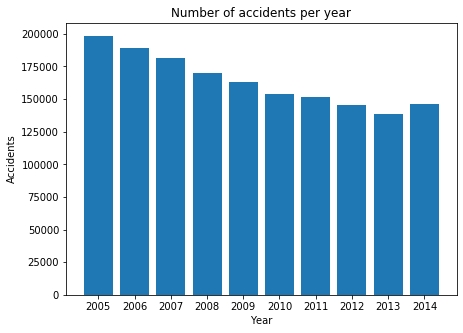

In [22]:
min_year, max_year = years.min(), years.max()
index_years = traffic_data.groupby('Year').size().index
size = traffic_data.groupby('Year').size()

plt.figure(figsize = (7, 5))

plt.bar(index_years, size)
plt.title("Number of accidents per year")
plt.xlabel("Year")
plt.ylabel("Accidents")
plt.xticks(range(min_year, max_year + 1))

plt.show()

Now we can proceed to examine the months, where we observe nothing out of the ordinary.

In [23]:
# Check:
# traffic_data.dtypes

Text(0, 0.5, 'Number of Accidents')

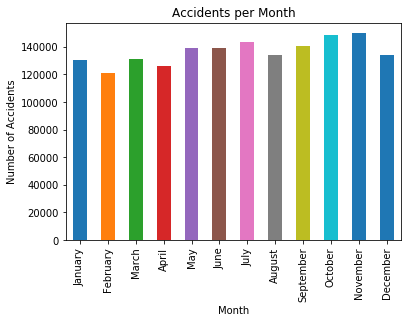

In [24]:
traffic_data['Month'] = traffic_data['Date'].dt.month
traffic_data.groupby('Month').size().plot(kind='bar', title='Accidents per Month')
plt.xticks(np.arange(12), calendar.month_name[1:13])
plt.ylabel('Number of Accidents')

Let's see how the chart would look if we plot the number of accidents for each day of the week.

In [25]:
weekdays = traffic_data.groupby("Day_of_Week").size()
weekdays

Day_of_Week
1    179806
2    232867
3    244875
4    246620
5    245645
6    268575
7    219667
dtype: int64

As per the dataset documentation, the UK considers the week to start with Sunday instead of Monday, so we take that into account when naming the labels.

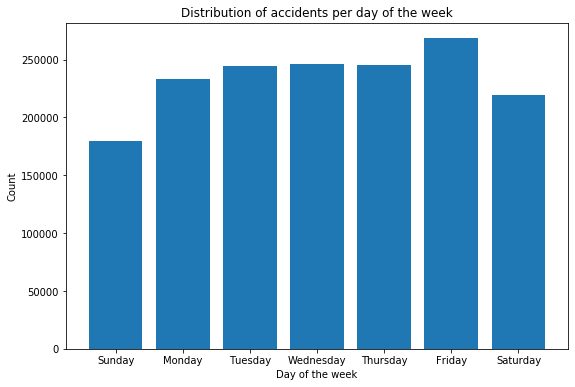

In [26]:
plt.title("Distribution of accidents per day of the week")
plt.bar(range(7), weekdays)
# As per the dataset documentation, the week starts with Sunday
plt.xticks(range(7), ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
plt.xlabel("Day of the week")
plt.ylabel("Count")
fig = plt.gcf()
fig.set_size_inches(9,6)
plt.show()

And here we can observe that significantly fewer accidents occur on Sundays, whereas the majority seem to happen on Friday.

In [27]:
accidents_by_day = traffic_data.groupby(traffic_data.Date.dt.date).size()

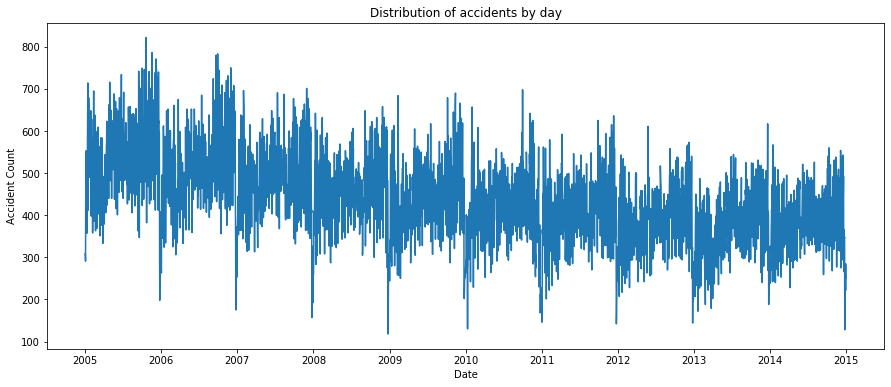

In [28]:
plt.figure(figsize = (15, 6))
plt.plot(accidents_by_day.index, accidents_by_day)
plt.title("Distribution of accidents by day")
plt.xlabel("Date")
plt.ylabel("Accident Count")
plt.show()

Judging by the chart above, there is a slow but steady downtrend in the frequency of accidents per day.

In [29]:
accident_time = traffic_data.groupby("Time").size()
accident_time.nlargest(10)

Time
17:00    15974
17:30    15201
16:00    14611
18:00    14403
15:30    14356
16:30    13865
08:30    12820
15:00    12780
18:30    11590
13:00    11569
dtype: int64

In [30]:
accident_time_top10 = accident_time.nlargest(10)
accident_time_top10

Time
17:00    15974
17:30    15201
16:00    14611
18:00    14403
15:30    14356
16:30    13865
08:30    12820
15:00    12780
18:30    11590
13:00    11569
dtype: int64

In [31]:
# traffic_data['Time'].value_counts().idxmax()
# traffic_data['Time'].value_counts().max()

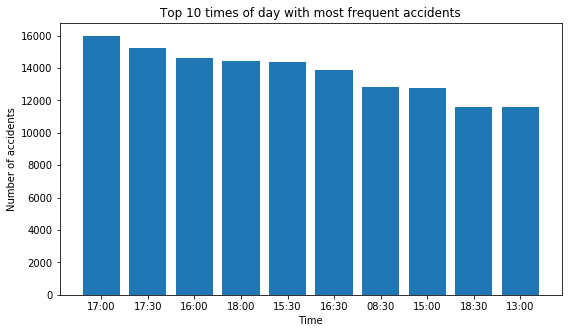

In [32]:
plt.title("Top 10 times of day with most frequent accidents")
plt.bar(range(10), accident_time_top10)
indices = accident_time.nlargest(10).index
plt.xticks(range(10), indices)
plt.xlabel("Time")
plt.ylabel("Number of accidents")
fig = plt.gcf()
fig.set_size_inches(9, 5)
plt.show()

Let's modify this chart to show hourly intervals instead of exact times to the minute.

In [33]:
def time_to_int(time):
    return int(time.replace(":", ""))

def is_in_interval(time, timeStart, timeEnd):
    if not time or time == "nan":
        return False
    return time_to_int(time) >= time_to_int(timeStart) and time_to_int(time) < time_to_int(timeEnd)

def get_interval(time, intervals):
    if not time or time == "nan":
        return ''
    for index, interval in enumerate(intervals):
        startTime = intervals[index]
        if index+1 >= len(intervals):
            endTime = intervals[0]
            if time_to_int(time) >= time_to_int(startTime):
                return startTime + "-" + endTime;
        else:
            endTime = intervals[index+1]

        if time_to_int(time) >= time_to_int(startTime) and time_to_int(time) < time_to_int(endTime):
            return startTime + "-" + endTime;


In [34]:
assert time_to_int("17:00") == 1700,"Not equal."
assert time_to_int("5:37") == 537,"Not equal."
assert time_to_int("07:34") == 734,"Not equal."
assert time_to_int("0:06") == 6,"Not equal."

assert is_in_interval("4:08", "2:00", "6:00"),"Not in interval."
assert is_in_interval("14:08", "18:00", "23:00") == False,"Should not be in interval."
assert is_in_interval("23:08", "22:00", "23:56"),"Not in interval."

In [35]:
def getDatasetsByTimeIntervals(intervals):
    trafic_data_by_intervals = []
    for index, interval in enumerate(intervals):
        startTime = intervals[index]
        if index+1 >= len(intervals):
            endTime = intervals[0]
        else:
            endTime = intervals[index+1]   
        trafic_data_by_intervals.append(traffic_data.loc[traffic_data['Time'].apply(str).apply(is_in_interval, args=[startTime, endTime])])
    return trafic_data_by_intervals
    

In [36]:
intervals = ['00:00', '01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00', '08:00', '09:00', '10:00', '11:00', '12:00',
             '13:00', '14:00', '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00', '23:00']

# Slow - iterates each interval to create a sub-dataset
# trafic_data_by_intervals = getDatasetsByTimeIntervals(intervals)
# for df in trafic_data_by_intervals:
#     print(df.shape)

# Faster - Add a new column with the time interval
traffic_data.insert(11, "Time Interval", traffic_data['Time'].apply(str).apply(get_interval, args=[intervals]))
traffic_data.head()


,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Year,Day_of_Week,Time,Time Interval,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month
0,200501BS00001,-0.191170,51.489096,1,2,1,1,2005-01-04,2005,3,17:42,17:00-18:00,3,6,30,1,2.0,2.0,1,1
1,200501BS00002,-0.211708,51.520075,1,3,1,1,2005-01-05,2005,4,17:36,17:00-18:00,4,3,30,4,1.0,1.0,1,1
2,200501BS00003,-0.206458,51.525301,1,3,2,1,2005-01-06,2005,5,00:15,00:00-01:00,5,6,30,4,1.0,1.0,1,1
3,200501BS00004,-0.173862,51.482442,1,3,1,1,2005-01-07,2005,6,10:35,10:00-11:00,3,6,30,1,1.0,1.0,1,1
4,200501BS00005,-0.156618,51.495752,1,3,1,1,2005-01-10,2005,2,21:13,21:00-22:00,6,6,30,7,1.0,2.0,1,1


In [37]:
interval_counts = traffic_data['Time Interval'].value_counts().sort_values()
# interval_counts

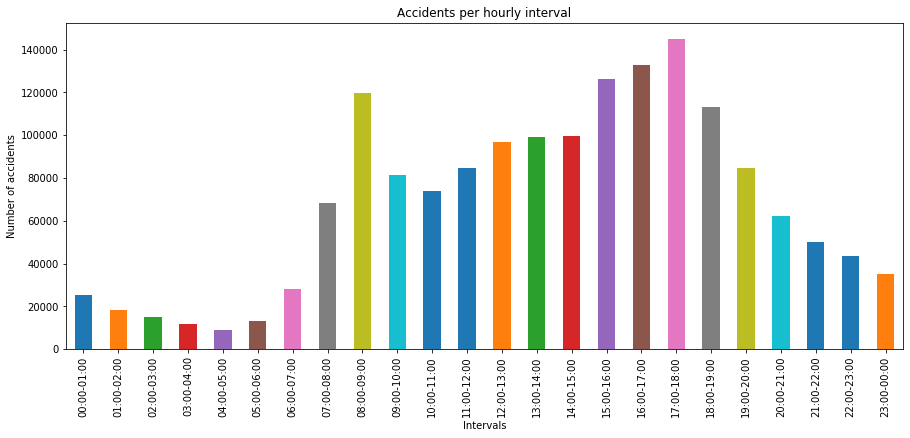

In [38]:
traffic_data[traffic_data["Time Interval"] != ""].sort_values(by = "Time Interval", ascending=True, inplace=False).groupby("Time Interval").size().plot(kind="bar")

plt.title("Accidents per hourly interval")
plt.xlabel("Intervals")
plt.ylabel("Number of accidents")

fig = plt.gcf()
fig.set_size_inches(15, 6)
plt.show()

It is hardly surprising that most accidents happen during rush hour, around 8-9 am and 17-18 pm.

In [39]:
road_surface_conditions = traffic_data.groupby("Road_Surface_Conditions").size()
road_surface_conditions

Road_Surface_Conditions
1.0    1124743
2.0     465450
3.0      10939
4.0      34524
5.0       2399
dtype: int64

In [ ]:
# road_surface_index = traffic_data.groupby("Road_Surface_Conditions").size().index.astype("str", copy=False)

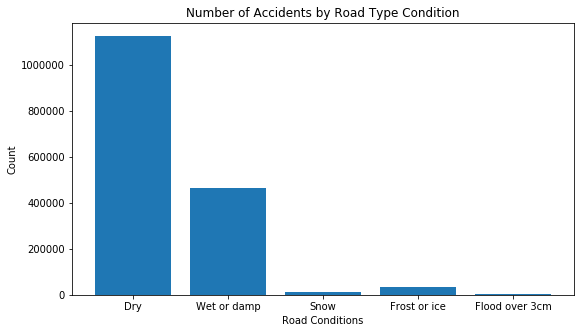

In [41]:
labels = ['Dry', 'Wet or damp', 'Snow', 'Frost or ice', 'Flood over 3cm']
plt.bar(labels, road_surface_conditions)
# Once again, the labels were retrieved from the documentation

# plt.xticks(np.arange(5), ['Dry', 'Wet or damp', 'Snow', 'Frost/ ice', 'Flood over 3cm'])
plt.xlabel("Road Conditions")
plt.ylabel("Count")
fig = plt.gcf()
fig.set_size_inches(9, 5)
plt.title('Number of Accidents by Road Type Condition')

plt.show()

In [42]:
fatal_accidents_by_road_condition = traffic_data[traffic_data['Accident_Severity'] == 1].groupby("Road_Surface_Conditions").size()
fatal_accidents_by_road_condition

Road_Surface_Conditions
1.0    14288
2.0     6587
3.0       79
4.0      364
5.0       47
dtype: int64

In [43]:
urban_rural = traffic_data.groupby("Urban_or_Rural_Area").size()
# Remove the third category which refers to unknown/missing data
urban_rural = urban_rural[urban_rural.index < 3]
urban_rural.head()

Urban_or_Rural_Area
1    1052832
2     585187
dtype: int64

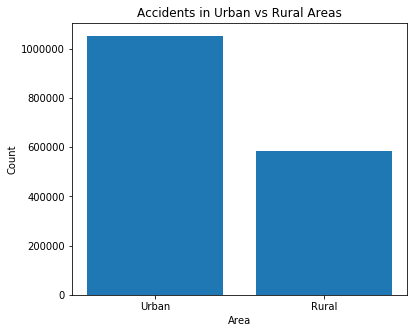

In [44]:
plt.title("Accidents in Urban vs Rural Areas")
plt.bar(["Urban", "Rural"], urban_rural)

# plt.xticks(range(2), ["Urban", "Rural"])
plt.xlabel("Area")
plt.ylabel("Count")
fig = plt.gcf()
fig.set_size_inches(6, 5)
plt.show()

In [45]:
traffic_by_speed = traffic_data.groupby("Speed_limit").size()
traffic_by_speed

Speed_limit
10         17
15         16
20      17717
30    1050293
40     134310
50      52830
60     262790
70     120082
dtype: int64

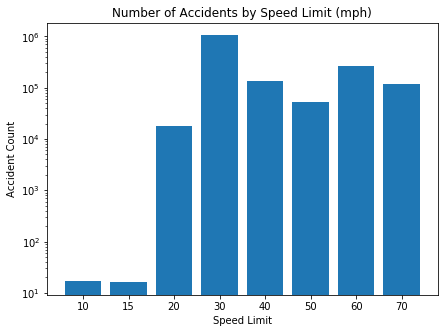

In [46]:
plt.figure(figsize = (7, 5))

plt.bar(traffic_by_speed.index.astype("str"), traffic_by_speed)

plt.title("Number of Accidents by Speed Limit (mph)")
plt.xlabel("Speed Limit")
plt.ylabel("Accident Count")

plt.yscale("log")

plt.show()

### Exploring Correlations in the Dataset

In [47]:
traffic_describe = traffic_data.describe()

# Identify potential candidates for removal (outliers):
traffic_describe.loc["+3_std"] = traffic_describe.loc["mean"] + (traffic_describe.loc["std"] * 3)
traffic_describe.loc["-3_std"] = traffic_describe.loc["mean"] - (traffic_describe.loc["std"] * 3)

traffic_describe

,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Year,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month
count,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06,1.638055e+06
mean,-1.437098e+00,5.258054e+01,3.081828e+01,2.838535e+00,1.831397e+00,1.351351e+00,2.009172e+03,4.117071e+00,4.089795e+00,5.166863e+00,3.910161e+01,1.950199e+00,1.573760e+00,1.366591e+00,1.357289e+00,6.648329e+00
std,1.404364e+00,1.454366e+00,2.554951e+01,4.018459e-01,7.154011e-01,8.263700e-01,2.887484e+00,1.924854e+00,1.430321e+00,1.644557e+00,1.417838e+01,1.647611e+00,1.635754e+00,6.241715e-01,4.792470e-01,3.426793e+00
min,-7.516225e+00,4.991294e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.005000e+03,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,-2.368340e+00,5.148866e+01,7.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00,2.007000e+03,2.000000e+00,3.000000e+00,6.000000e+00,3.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00
50%,-1.400396e+00,5.228759e+01,3.100000e+01,3.000000e+00,2.000000e+00,1.000000e+00,2.009000e+03,4.000000e+00,4.000000e+00,6.000000e+00,3.000000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,7.000000e+00
75%,-2.211880e-01,5.346837e+01,4.600000e+01,3.000000e+00,2.000000e+00,1.000000e+00,2.012000e+03,6.000000e+00,6.000000e+00,6.000000e+00,5.000000e+01,4.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00,1.000000e+01
max,1.762010e+00,6.075754e+01,9.800000e+01,3.000000e+00,6.700000e+01,9.300000e+01,2.014000e+03,7.000000e+00,6.000000e+00,9.000000e+00,7.000000e+01,7.000000e+00,9.000000e+00,5.000000e+00,3.000000e+00,1.200000e+01
+3_std,2.775995e+00,5.694364e+01,1.074668e+02,4.044073e+00,3.977600e+00,3.830461e+00,2.017835e+03,9.891634e+00,8.380757e+00,1.010053e+01,8.163674e+01,6.893031e+00,6.481021e+00,3.239106e+00,2.795030e+00,1.692871e+01
-3_std,-5.650191e+00,4.821744e+01,-4.583025e+01,1.632997e+00,-3.148064e-01,-1.127759e+00,2.000510e+03,-1.657491e+00,-2.011672e-01,2.331929e-01,-3.433529e+00,-2.992632e+00,-3.333502e+00,-5.059238e-01,-8.045193e-02,-3.632049e+00


,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Year,Day_of_Week,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Weather_Conditions,Road_Surface_Conditions,Urban_or_Rural_Area,Month
Longitude,1.000000,-0.429317,-0.378185,0.014516,0.020139,-0.037953,0.039662,-0.002274,-0.057949,-0.012040,-0.060444,0.007979,-0.029500,-0.069271,-0.092540,0.005820
Latitude,-0.429317,1.000000,0.177383,-0.032312,-0.042417,0.030305,-0.022220,0.003950,0.033961,0.011706,0.046526,0.006053,0.017322,0.082827,0.050476,-0.003160
Police_Force,-0.378185,0.177383,1.000000,-0.034079,-0.017637,0.005626,-0.013968,0.000352,0.044523,-0.014763,0.195531,0.019824,0.047346,0.080423,0.239096,0.000128
Accident_Severity,0.014516,-0.032312,-0.034079,1.000000,0.075308,-0.085736,-0.004260,0.002638,0.012943,-0.039401,-0.080279,-0.063880,0.022350,0.011296,-0.083195,-0.001928
Number_of_Vehicles,0.020139,-0.042417,-0.017637,0.075308,1.000000,0.235329,-0.006871,-0.000294,-0.142388,-0.074977,0.083481,-0.085459,-0.019643,-0.041613,0.039881,0.005118
Number_of_Casualties,-0.037953,0.030305,0.005626,-0.085736,0.235329,1.000000,-0.014646,-0.001217,-0.082857,-0.011379,0.138330,0.037744,-0.003913,0.027927,0.115393,0.001567
Year,0.039662,-0.022220,-0.013968,-0.004260,-0.006871,-0.014646,1.000000,-0.003164,-0.009518,0.000797,-0.039128,-0.007803,-0.018033,-0.003083,-0.018009,0.003018
Day_of_Week,-0.002274,0.003950,0.000352,0.002638,-0.000294,-0.001217,-0.003164,1.000000,0.006923,0.005870,-0.016421,0.008036,-0.000890,-0.010334,-0.016832,0.002397
1st_Road_Class,-0.057949,0.033961,0.044523,0.012943,-0.142388,-0.082857,-0.009518,0.006923,1.000000,0.292482,-0.390944,-0.038216,0.010768,0.002735,-0.228110,-0.002891
Road_Type,-0.012040,0.011706,-0.014763,-0.039401,-0.074977,-0.011379,0.000797,0.005870,0.292482,1.000000,-0.200807,-0.001203,0.004641,0.015082,-0.043859,-0.003789


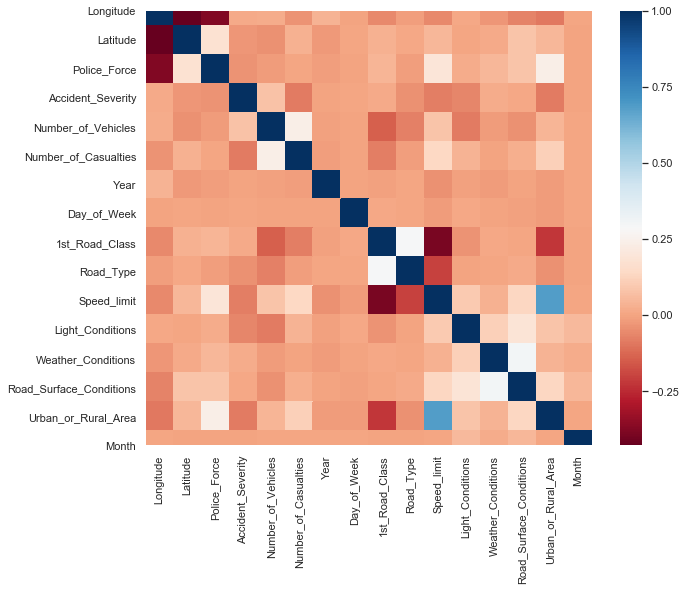

In [48]:
# Calculate the correlation matrix:
corr = traffic_data.corr()

# Display the correlation matrix:
display(corr)

# Plot the correlation heatmap:
sns.set(rc={'figure.figsize':(10,8)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')


Values in the correlation matrix range from 1 (indicating very strong positve correlation) to -1 (very strong negative correlation), via 0 (no relationship).

In [49]:
road_condition_by_accident = traffic_data.groupby("Accident_Severity")["Road_Surface_Conditions"]

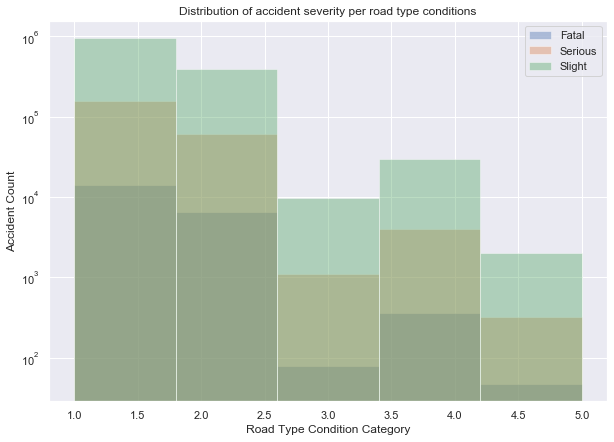

In [127]:
plt.figure(figsize = (10, 7))
label_list = ["Fatal", "Serious", "Slight"]
for a_sev, roadtypeconditions in road_condition_by_accident:
    plt.hist(roadtypeconditions, label = label_list[a_sev - 1], alpha = 0.4, bins = 5)
plt.title("Distribution of accident severity per road type conditions")
plt.yscale("log")
plt.legend()
plt.xlabel("Road Type Condition Category")
plt.ylabel("Accident Count")
# plt.xticks(np.arange(5), ["Dry", "Wet or damp", "Snow", "Frost or ice", "Flood over 3cm"])
plt.show()

We observe that the majority of accidents (in all severity categories) fall within the first two road type classes (respectively dry and wet/damp road, as stated in the documentation).<br>There is a left tail to the distribution.

### Perform Hypothesis Testing on Severity vs Road Condition

**𝐻0**: Accident severity is not correlated with specific road surface conditions; the variation in the data is due to chance.<br>
**𝐻1**: The differences are not coincidental.<br>
Let's assume a 1% threshold value of  𝑝 (0.01). If 𝑝 ≤ 0.01%, we will reject 𝐻0.

In [51]:
fatal_accidents = road_condition_by_accident.get_group(1)
serious_accidents = road_condition_by_accident.get_group(2)
slight_accidents = road_condition_by_accident.get_group(3)

In [52]:
assert(fatal_accidents.shape[0] + serious_accidents.shape[0] + slight_accidents.shape[0] == traffic_data.shape[0])

In [53]:
test_result = ttest_ind(fatal_accidents, serious_accidents, equal_var = False)
print(test_result)

print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")
    
descriptives, test_result = rp.ttest(fatal_accidents, serious_accidents)
print(test_result)

display(descriptives)

Ttest_indResult(statistic=7.276005602251172, pvalue=3.5376347191076797e-13)
3.5376347191076797e-13
The differences are significant. Reject H0.
                                  Independent t-test      results
0  Difference (Road_Surface_Conditions - Road_Sur...       0.0317
1                              Degrees of freedom =   243122.0000
2                                               t =        7.3566
3                           Two side test p value =        0.0000
4                          Difference > 0 p value =        1.0000
5                          Difference < 0 p value =        0.0000
6                                       Cohen's d =        0.0527
7                                       Hedge's g =        0.0527
8                                   Glass's delta =        0.0521
9                                               r =        0.0149


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Road_Surface_Conditions,21365.0,1.375614,0.608738,0.004165,1.367451,1.383777
1,Road_Surface_Conditions,221759.0,1.343923,0.600657,0.001276,1.341423,1.346423
2,combined,243124.0,1.346708,0.601437,0.001220,1.344317,1.349099


In [54]:
test_result = ttest_ind(fatal_accidents, slight_accidents, equal_var = False)
print(test_result)

print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")
    
descriptives, test_result = rp.ttest(fatal_accidents, slight_accidents)
print(test_result)

display(descriptives)

Ttest_indResult(statistic=1.3238243516184667, pvalue=0.18557510041419606)
0.18557510041419606
There's not enough evidence to reject H0. Don't accept or reject anything else.
                                  Independent t-test       results
0  Difference (Road_Surface_Conditions - Road_Sur...  5.600000e-03
1                              Degrees of freedom =   1.416294e+06
2                                               t =   1.284500e+00
3                           Two side test p value =   1.990000e-01
4                          Difference > 0 p value =   9.005000e-01
5                          Difference < 0 p value =   9.950000e-02
6                                       Cohen's d =   8.900000e-03
7                                       Hedge's g =   8.900000e-03
8                                   Glass's delta =   9.100000e-03
9                                               r =   1.100000e-03


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Road_Surface_Conditions,21365.0,1.375614,0.608738,0.004165,1.367451,1.383777
1,Road_Surface_Conditions,1394931.0,1.370056,0.627986,0.000532,1.369014,1.371098
2,combined,1416296.0,1.370140,0.627700,0.000527,1.369106,1.371174


In [55]:
test_result = ttest_ind(serious_accidents, slight_accidents, equal_var = False)
print(test_result)

print(test_result.pvalue)
if test_result.pvalue <= 0.01:
    print("The differences are significant. Reject H0.")
else:
    print("There's not enough evidence to reject H0. Don't accept or reject anything else.")
    
descriptives, test_result = rp.ttest(serious_accidents, slight_accidents)
print(test_result)

display(descriptives)

Ttest_indResult(statistic=-18.91117892034931, pvalue=1.0255416485310707e-79)
1.0255416485310707e-79
The differences are significant. Reject H0.
                                  Independent t-test       results
0  Difference (Road_Surface_Conditions - Road_Sur... -2.610000e-02
1                              Degrees of freedom =   1.616688e+06
2                                               t =  -1.831050e+01
3                           Two side test p value =   0.000000e+00
4                          Difference > 0 p value =   0.000000e+00
5                          Difference < 0 p value =   1.000000e+00
6                                       Cohen's d =  -4.190000e-02
7                                       Hedge's g =  -4.190000e-02
8                                   Glass's delta =  -4.350000e-02
9                                               r =   1.440000e-02


,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Road_Surface_Conditions,221759.0,1.343923,0.600657,0.001276,1.341423,1.346423
1,Road_Surface_Conditions,1394931.0,1.370056,0.627986,0.000532,1.369014,1.371098
2,combined,1616690.0,1.366472,0.624372,0.000491,1.365509,1.367434


### Chi Squared
The Chi-square test is intended to test how likely it is that an observed distribution is due to chance. It is also called a "goodness of fit" statistic, because it measures how well the observed distribution of data fits with the distribution that is expected if the variables are independent.

In [57]:
severity = traffic_data["Accident_Severity"]
roadconditions = traffic_data["Road_Surface_Conditions"]

# Contingency table
table = pd.crosstab(severity, roadconditions)

# Chi-square test of independence:
chi2, p, dof, expected = chi2_contingency(table.values)

print('Chi-square Statistic: %0.3f' % (chi2))
print('Degree of Freedom: %0.3f' % (dof))

Chi-square Statistic: 516.110
Degree of Freedom: 8.000


In [58]:
# Display the contingency table
table

Road_Surface_Conditions,1.0,2.0,3.0,4.0,5.0
Accident_Severity,,,,,
1,14288,6587,79,364,47
2,155519,60845,1086,3985,324
3,954936,398018,9774,30175,2028


### Spearman Rank Correlation
Spearman Rank Correlation quantifies the degree to which ranked variables are associated by a monotonic function, meaning an increasing or decreasing relationship. It is applicable for both continuous and discrete ordinal variables. As a statistical hypothesis test, the method assumes that the samples are uncorrelated (failure to reject H0).

In [59]:
# severity = traffic_data["Accident_Severity"]
# roadconditions = traffic_data["Road_Surface_Conditions"]

spearmanr_coefficient, p_value = spearmanr(severity, roadconditions)

print("Spearman Rank Correlation: %0.3f" % (spearmanr_coefficient))
# a very slight positive correlation

print(p_value)

Spearman Rank Correlation: 0.011
2.553367052680441e-47


### Preparing the Data for Modelling - Indicator Variables

In [60]:
# traffic_data_for_modelling = pd.get_dummies(traffic_data, columns = ["Light_Conditions", "Road_Surface_Conditions", "Weather_Conditions", "Urban_or_Rural_Area"])

traffic_data_for_modelling = pd.get_dummies(traffic_data, columns = ["Road_Surface_Conditions", "Weather_Conditions"])

traffic_data_for_modelling.head()

,Accident_Index,Longitude,Latitude,Police_Force,Accident_Severity,Number_of_Vehicles,Number_of_Casualties,Date,Year,Day_of_Week,Time,Time Interval,1st_Road_Class,Road_Type,Speed_limit,Light_Conditions,Urban_or_Rural_Area,Month,Road_Surface_Conditions_1.0,Road_Surface_Conditions_2.0,Road_Surface_Conditions_3.0,Road_Surface_Conditions_4.0,Road_Surface_Conditions_5.0,Weather_Conditions_1.0,Weather_Conditions_2.0,Weather_Conditions_3.0,Weather_Conditions_4.0,Weather_Conditions_5.0,Weather_Conditions_6.0,Weather_Conditions_7.0,Weather_Conditions_8.0,Weather_Conditions_9.0
0,200501BS00001,-0.191170,51.489096,1,2,1,1,2005-01-04,2005,3,17:42,17:00-18:00,3,6,30,1,1,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0
1,200501BS00002,-0.211708,51.520075,1,3,1,1,2005-01-05,2005,4,17:36,17:00-18:00,4,3,30,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,200501BS00003,-0.206458,51.525301,1,3,2,1,2005-01-06,2005,5,00:15,00:00-01:00,5,6,30,4,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
3,200501BS00004,-0.173862,51.482442,1,3,1,1,2005-01-07,2005,6,10:35,10:00-11:00,3,6,30,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0
4,200501BS00005,-0.156618,51.495752,1,3,1,1,2005-01-10,2005,2,21:13,21:00-22:00,6,6,30,7,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0


In [61]:
traffic_data_features = traffic_data_for_modelling.drop(["Accident_Severity", 
                                                         "Time Interval", 
                                                         "Accident_Index", 
                                                         "Time", 
                                                         "Date"], axis = 1)

traffic_data_target = traffic_data_for_modelling.Accident_Severity

#### Because our values are categorical and in similar ranges, we do not need normalization.

### Splitting the Data
In regard to splitting the data for training and testing, we will use a 70% / 30% ratio.

In [62]:
features_train, features_test, target_train, target_test = train_test_split(traffic_data_features, traffic_data_target, train_size = 0.7, test_size = 0.3, random_state = 42)
print(features_train.shape, features_test.shape, target_train.shape, target_test.shape, sep = "\r\n")

(1146638, 27)
(491417, 27)
(1146638,)
(491417,)


In [63]:
features_train.dtypes

Longitude                      float64
Latitude                       float64
Police_Force                     int64
Number_of_Vehicles               int64
Number_of_Casualties             int64
Year                             int64
Day_of_Week                      int64
1st_Road_Class                   int64
Road_Type                        int64
Speed_limit                      int64
Light_Conditions                 int64
Urban_or_Rural_Area              int64
Month                            int64
Road_Surface_Conditions_1.0      uint8
Road_Surface_Conditions_2.0      uint8
Road_Surface_Conditions_3.0      uint8
Road_Surface_Conditions_4.0      uint8
Road_Surface_Conditions_5.0      uint8
Weather_Conditions_1.0           uint8
Weather_Conditions_2.0           uint8
Weather_Conditions_3.0           uint8
Weather_Conditions_4.0           uint8
Weather_Conditions_5.0           uint8
Weather_Conditions_6.0           uint8
Weather_Conditions_7.0           uint8
Weather_Conditions_8.0   

### Modelling the Data

In [64]:
model = LogisticRegression()
model.fit(features_train, target_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [65]:
model.coef_

array([[-8.98879988e-03,  5.60456185e-02,  1.27416008e-03,
        -2.03290139e-01,  3.21148223e-01, -5.19190492e-03,
        -2.45655302e-03, -9.70529886e-02,  1.57532909e-01,
         2.53609035e-02,  1.53864882e-01,  4.51205113e-01,
         2.92311433e-03,  1.54975281e-01,  1.61340734e-01,
        -8.19709599e-02, -2.25701679e-01, -6.79858051e-03,
         3.06519449e-01, -1.16163064e-01, -6.72299359e-02,
         9.54726728e-02, -4.59632327e-02, -2.22941375e-02,
         1.01056856e-02, -1.18875079e-01, -3.97275616e-02],
       [ 2.50403634e-02,  3.96916458e-02,  1.46394784e-03,
        -4.42143300e-01,  2.17775211e-01, -2.32858893e-03,
        -2.21087936e-03,  8.36265748e-03,  7.57365757e-02,
         5.28944547e-03,  4.94108680e-02,  1.76150291e-01,
         6.45911239e-04,  1.23635390e-01,  3.15665159e-02,
        -3.93790826e-02, -1.12155945e-01, -4.97244201e-03,
         1.68927641e-01, -9.61920190e-03, -3.91552201e-02,
         2.37252346e-02, -3.42693208e-03, -6.66745121e-

### Scoring the Model

In [66]:
score = model.score(features_test, target_test)
score

0.8513136501179243

The accuracy of our model is 0.85

## Geospatial Plotting with Folium

Due to performance issues, it is recommended to use filters, e.g. plot one year at a time, in order to reduce the dataset size.

In [67]:
dataset = traffic_data

map_uk = folium.Map(location=[52.6, -1],zoom_start = 7) 

dataset['Latitude'] = dataset['Latitude'].astype(float)
dataset['Longitude'] = dataset['Longitude'].astype(float)

heat_df = dataset[dataset['Speed_limit'] == 50]
heat_df = heat_df[heat_df['Year'] == 2014]
heat_df = heat_df[['Latitude', 'Longitude']]

heat_df['Weight'] = dataset['Date'].astype(str)
heat_df['Weight'] = heat_df['Weight'].str[5:7].astype(float)
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude', 'Weight'])

# List comprehension
heat_data = [[[row['Latitude'],row['Longitude']] for index, row in heat_df[heat_df['Weight'] == i].iterrows()] for i in range(1,13)]

# print(heat_df)

hm = plugins.HeatMapWithTime(heat_data,auto_play=False,max_opacity=0.8)
hm.add_to(map_uk)

# Display the map
map_uk

## Geospatial Plotting with Basemap

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


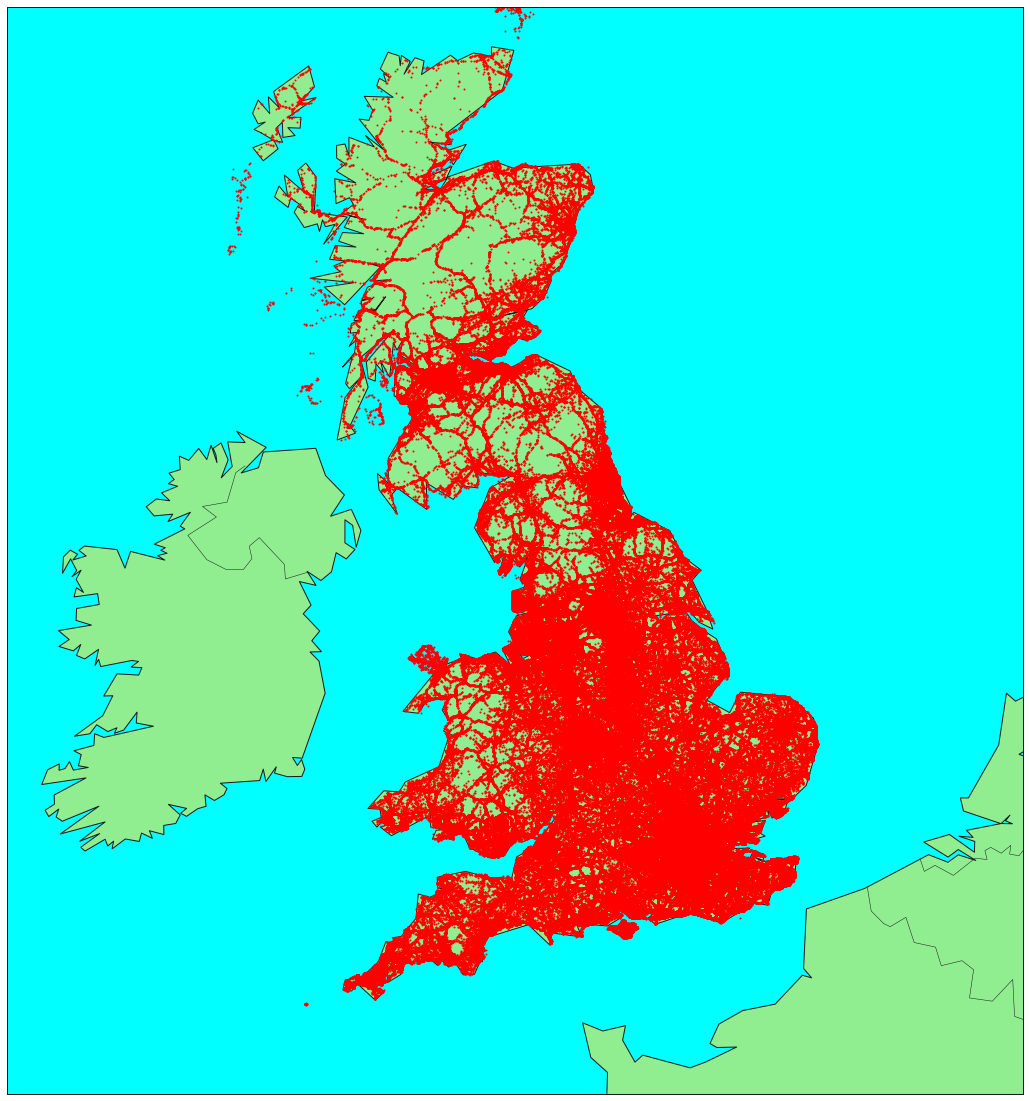

In [68]:
tdata = traffic_data

#  tdata = dataset[dataset['Speed_limit'] == 50]
#  tdata = tdata[tdata['Year'] == 2012]

plt.figure(figsize = (28, 20))
m = Basemap(projection = "merc", llcrnrlat = 49, llcrnrlon = -11, urcrnrlat = 59, urcrnrlon = 5, resolution="l")
x, y = m(tdata['Longitude'].tolist(), tdata['Latitude'].tolist())
m.plot(x,y,"o", markersize = 1, color = "red")

# raise NotImplementedError()
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = "lightgreen", lake_color = "aqua")
m.drawmapboundary(fill_color = "aqua")
plt.show()

It should be noted that the datasets do not include data for Northern Ireland.

## The Vehicles Dataset

In [69]:
vehicles_data_full = pd.read_csv("Vehicles0514.csv")
vehicles_data_full = vehicles_data_full.replace(-1, np.nan)

vehicles_data_full.shape

(3004425, 22)

In [ ]:
# vehicles_data = vehicles_data_full.iloc[:100000]

In [71]:
vehicles_data_full.head()

,Accident_Index,Vehicle_Reference,Vehicle_Type,Towing_and_Articulation,Vehicle_Manoeuvre,Vehicle_Location-Restricted_Lane,Junction_Location,Skidding_and_Overturning,Hit_Object_in_Carriageway,Vehicle_Leaving_Carriageway,Hit_Object_off_Carriageway,1st_Point_of_Impact,Was_Vehicle_Left_Hand_Drive?,Journey_Purpose_of_Driver,Sex_of_Driver,Age_of_Driver,Age_Band_of_Driver,Engine_Capacity_(CC),Propulsion_Code,Age_of_Vehicle,Driver_IMD_Decile,Driver_Home_Area_Type
0,200501BS00001,1,9.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,15.0,2.0,74.0,10.0,NaN,NaN,NaN,7.0,1.0
1,200501BS00002,1,11.0,0.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,42.0,7.0,8268.0,2.0,3.0,NaN,NaN
2,200501BS00003,1,11.0,0.0,17.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,1.0,1.0,1.0,35.0,6.0,8300.0,2.0,5.0,2.0,1.0
3,200501BS00003,2,9.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,15.0,1.0,62.0,9.0,1762.0,1.0,6.0,1.0,1.0
4,200501BS00004,1,9.0,0.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,15.0,2.0,49.0,8.0,1769.0,1.0,4.0,2.0,1.0


In [72]:
# vehicles_data.info()
display(vehicles_data_full.isnull().any())
display(vehicles_data_full.isnull().sum())

Accident_Index                      False
Vehicle_Reference                   False
Vehicle_Type                         True
Towing_and_Articulation              True
Vehicle_Manoeuvre                    True
Vehicle_Location-Restricted_Lane     True
Junction_Location                    True
Skidding_and_Overturning             True
Hit_Object_in_Carriageway            True
Vehicle_Leaving_Carriageway          True
Hit_Object_off_Carriageway           True
1st_Point_of_Impact                  True
Was_Vehicle_Left_Hand_Drive?         True
Journey_Purpose_of_Driver            True
Sex_of_Driver                        True
Age_of_Driver                        True
Age_Band_of_Driver                   True
Engine_Capacity_(CC)                 True
Propulsion_Code                      True
Age_of_Vehicle                       True
Driver_IMD_Decile                    True
Driver_Home_Area_Type                True
dtype: bool

Accident_Index                           0
Vehicle_Reference                        0
Vehicle_Type                           473
Towing_and_Articulation                184
Vehicle_Manoeuvre                     1080
Vehicle_Location-Restricted_Lane        74
Junction_Location                     9876
Skidding_and_Overturning               132
Hit_Object_in_Carriageway               87
Vehicle_Leaving_Carriageway            127
Hit_Object_off_Carriageway              54
1st_Point_of_Impact                    565
Was_Vehicle_Left_Hand_Drive?         23049
Journey_Purpose_of_Driver            44921
Sex_of_Driver                           33
Age_of_Driver                       330608
Age_Band_of_Driver                  330608
Engine_Capacity_(CC)                788471
Propulsion_Code                     770004
Age_of_Vehicle                      874989
Driver_IMD_Decile                   849921
Driver_Home_Area_Type               588611
dtype: int64

### Feature Selection & Handling NaNs

In [73]:
vehicles_data = vehicles_data_full[["Sex_of_Driver", "Age_of_Driver", "Age_of_Vehicle", "Age_Band_of_Driver"]].copy(deep=True)
vehicles_data.head()

,Sex_of_Driver,Age_of_Driver,Age_of_Vehicle,Age_Band_of_Driver
0,2.0,74.0,NaN,10.0
1,1.0,42.0,3.0,7.0
2,1.0,35.0,5.0,6.0
3,1.0,62.0,6.0,9.0
4,2.0,49.0,4.0,8.0


In [ ]:
    # vehicles_data.hist(bins=25, figsize=(16, 12))
    # plt.show()

In [74]:
vehicles_data.isnull().sum()

Sex_of_Driver             33
Age_of_Driver         330608
Age_of_Vehicle        874989
Age_Band_of_Driver    330608
dtype: int64

The following code snippet shows how we would **impute the missing values** in the Age columns with the help of SimpleImputer. **However**, traditional approaches for working with missing values can lead to biased estimates and may either reduce or exaggerate statistical power, and each of these distortions can lead to invalid conclusions.
Having already performed the imputation once, it was obvious that the results were indeed distorted. Therefore, the imputation method will not be used but will be left purely to demonstrate how it's done.

In [75]:
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
    
# imp.fit(vehicles_data.iloc[:, 1:2])
# vehicles_data["Age_of_Driver"] = imp.transform(vehicles_data.iloc[:, 1:2])

# vehicles_data.isnull().sum()

In [76]:
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")

# imp.fit(vehicles_data.iloc[:, 2:3])
# vehicles_data["Age_of_Vehicle"] = imp.transform(vehicles_data.iloc[:, 2:3])

# vehicles_data.isnull().sum()

### Tidying the Driver Sex Column

In [77]:
vehicles_data["Sex_of_Driver"].value_counts()
vehicles_data["Sex_of_Driver"].max()
# According to the documentation file, "3" refers to unknown data and should be handled

3.0

In [78]:
vehicles_data["Sex_of_Driver"].replace(3, np.nan, inplace=True)

In [79]:
# Check if the genders category has been successfully corrected:
assert(len(vehicles_data["Sex_of_Driver"].value_counts()) == 2)

vehicles_data["Sex_of_Driver"].value_counts()

1.0    1978150
2.0     852519
Name: Sex_of_Driver, dtype: int64

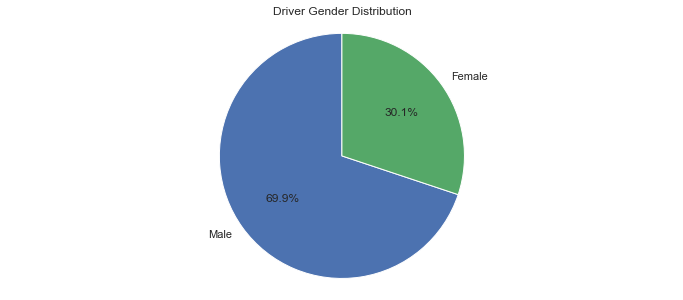

In [80]:
plt.figure(figsize = (12, 5))
pie_chart = vehicles_data.groupby(vehicles_data["Sex_of_Driver"])["Sex_of_Driver"].count()
labels=['Male','Female']
color = ['b','g']
 
plt.pie(pie_chart, labels=labels, colors=color, startangle=90, shadow= False, autopct='%1.1f%%')
 
plt.axis('equal')
plt.title('Driver Gender Distribution')
plt.show()

### Imputing the gender column - the same reasoning applies as described above in the case of age imputation.

In [84]:
# Creating a random generator for the gender variable following 
# the distribution observed above (approx.70% male vs 30% female)

import random

def gender_ratio_generator():
    sex = random.uniform(0, 1)
    if sex > 0.30:
        return 1
    else:
        return 2

list = []
for i in range(11):
    list.append(gender_ratio_generator())
print(list)

[2, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1]


In [85]:
# vehicles_data["Sex_of_Driver"].replace(np.nan, gender_ratio_generator(), inplace = True)

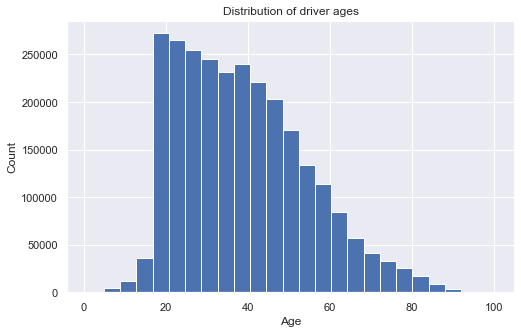

In [86]:
vehicles_data["Age_of_Driver"].hist(bins=25, figsize=(8, 5))
plt.title("Distribution of driver ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

In [87]:
# vehicles_data["Age_Band_of_Driver"].value_counts().sort_values()

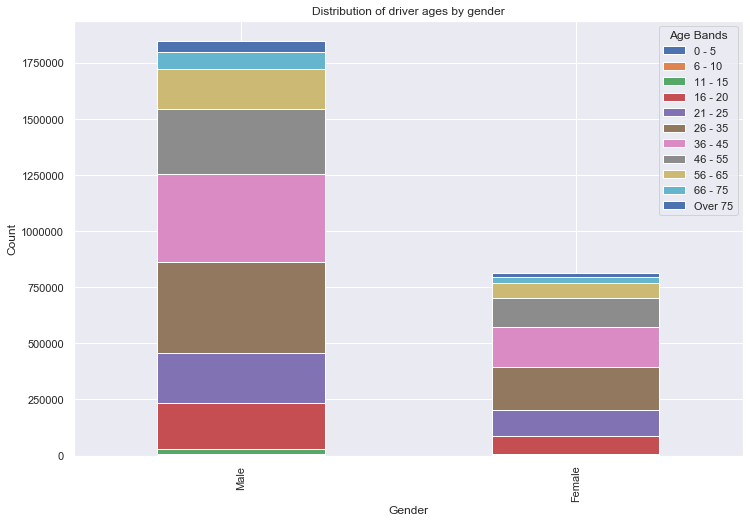

In [88]:
counts = vehicles_data.groupby(['Sex_of_Driver', 'Age_Band_of_Driver']).Sex_of_Driver.count().unstack()

counts.plot(kind='bar', stacked=True)
age_bands = ["0 - 5", "6 - 10", "11 - 15", "16 - 20", "21 - 25", "26 - 35", "36 - 45", "46 - 55", "56 - 65", "66 - 75", "Over 75"]
# The Age Bands description was retrieved from the documentation file

plt.title("Distribution of driver ages by gender")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.xticks(np.arange(2), ["Male", "Female"])
plt.legend(age_bands, title = "Age Bands")
fig = plt.gcf()
fig.set_size_inches(12, 8)
plt.show()

In [89]:
corr = vehicles_data.corr()

# Display the correlation matrix:
display(corr)

,Sex_of_Driver,Age_of_Driver,Age_of_Vehicle,Age_Band_of_Driver
Sex_of_Driver,1.000000,-0.017261,-0.031580,-0.011460
Age_of_Driver,-0.017261,1.000000,-0.036007,0.977813
Age_of_Vehicle,-0.031580,-0.036007,1.000000,-0.042469
Age_Band_of_Driver,-0.011460,0.977813,-0.042469,1.000000


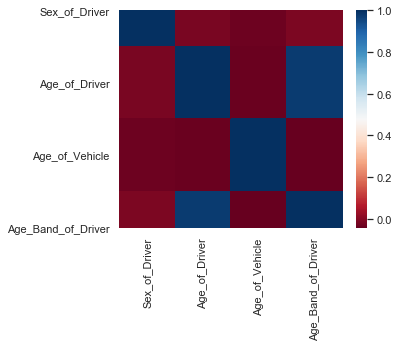

In [90]:
# Plot the correlation heatmap:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [91]:
# vehicles_data["Age_of_Vehicle"].value_counts()

In [92]:
vehicle_ages = vehicles_data.groupby("Age_of_Vehicle").size()
vehicle_ages.nlargest(10)

Age_of_Vehicle
1.0     173765
6.0     169545
5.0     168906
7.0     168475
4.0     168096
2.0     165718
8.0     164633
3.0     163631
9.0     157562
10.0    146691
dtype: int64

In [93]:
vehicles_data["Age_of_Vehicle"].max()

111.0

Surprisingly, it seems that the oldest vehicle to be involved in a traffic accident in the UK is 111 years old!<br><br>
Now, let's plot the number of accidents per vehicle age. Here it makes sense to make the y-axis logarithmic, as the vast majority of accidents are concentrated in the newest vehicle age band.

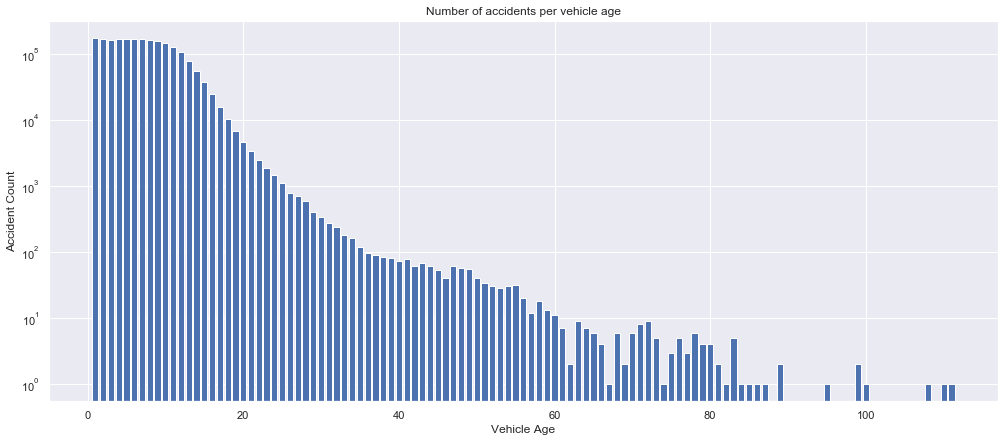

In [94]:
plt.figure(figsize = (17, 7))

plt.bar(vehicle_ages.index, vehicle_ages)

plt.title("Number of accidents per vehicle age")
plt.xlabel("Vehicle Age")
plt.ylabel("Accident Count")
# Make the scale logarithmic:
plt.yscale("log")
plt.show()


## The Casualties Dataset

To a large extent, we proceed in the same way as above when preparing the previous datasets.

In [95]:
casualties_data_full = pd.read_csv("Casualties0514.csv")
casualties_data_full = casualties_data_full.replace(-1, np.nan)

casualties_data_full.shape

(2216720, 15)

In [ ]:
# casualties_data = casualties_data_full.iloc[:100000]

In [96]:
casualties_data_full.head()

,Accident_Index,Vehicle_Reference,Casualty_Reference,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Pedestrian_Location,Pedestrian_Movement,Car_Passenger,Bus_or_Coach_Passenger,Pedestrian_Road_Maintenance_Worker,Casualty_Type,Casualty_Home_Area_Type
0,200501BS00001,1,1,3,1.0,37.0,7.0,2,1.0,1.0,0.0,0.0,NaN,0,1.0
1,200501BS00002,1,1,2,1.0,37.0,7.0,3,0.0,0.0,0.0,4.0,NaN,11,1.0
2,200501BS00003,2,1,1,1.0,62.0,9.0,3,0.0,0.0,0.0,0.0,NaN,9,1.0
3,200501BS00004,1,1,3,1.0,30.0,6.0,3,5.0,2.0,0.0,0.0,NaN,0,1.0
4,200501BS00005,1,1,1,1.0,49.0,8.0,3,0.0,0.0,0.0,0.0,NaN,3,NaN


In [97]:
display(casualties_data_full.isnull().any())

Accident_Index                        False
Vehicle_Reference                     False
Casualty_Reference                    False
Casualty_Class                        False
Sex_of_Casualty                        True
Age_of_Casualty                        True
Age_Band_of_Casualty                   True
Casualty_Severity                     False
Pedestrian_Location                    True
Pedestrian_Movement                    True
Car_Passenger                          True
Bus_or_Coach_Passenger                 True
Pedestrian_Road_Maintenance_Worker     True
Casualty_Type                         False
Casualty_Home_Area_Type                True
dtype: bool

In [98]:
casualties_data = casualties_data_full[["Casualty_Class",
                                        "Sex_of_Casualty",
                                        "Age_of_Casualty",
                                        "Age_Band_of_Casualty",
                                        "Casualty_Severity",
                                        "Casualty_Type"]].copy(deep=True)

In [99]:
casualties_data.isnull().sum()

Casualty_Class              0
Sex_of_Casualty           630
Age_of_Casualty         45920
Age_Band_of_Casualty    45920
Casualty_Severity           0
Casualty_Type               0
dtype: int64

In [100]:
casualties_data.dropna(subset = ["Sex_of_Casualty", 
                              "Age_of_Casualty", 
                              "Age_Band_of_Casualty"], inplace = True)

In [101]:
assert(casualties_data.isnull().sum().sum() == 0)

In [ ]:
# casualties_data.hist(bins=50, figsize=(16, 12))
# plt.show()

,Casualty_Class,Sex_of_Casualty,Age_of_Casualty,Age_Band_of_Casualty,Casualty_Severity,Casualty_Type
Casualty_Class,1.000000,0.129954,-0.121091,-0.180242,-0.068191,-0.259246
Sex_of_Casualty,0.129954,1.000000,0.048172,0.040696,0.086268,0.038581
Age_of_Casualty,-0.121091,0.048172,1.000000,0.975025,-0.049210,0.091514
Age_Band_of_Casualty,-0.180242,0.040696,0.975025,1.000000,-0.040450,0.104814
Casualty_Severity,-0.068191,0.086268,-0.049210,-0.040450,1.000000,0.079626
Casualty_Type,-0.259246,0.038581,0.091514,0.104814,0.079626,1.000000


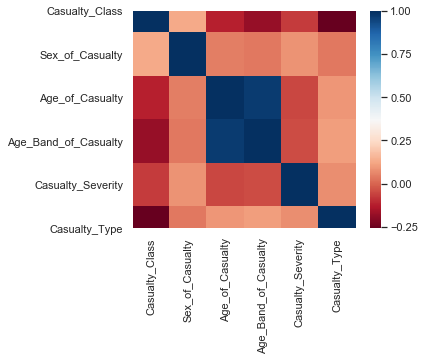

In [102]:
corr = casualties_data.corr()

# Display the correlation matrix:
display(corr)

# Plot the correlation heatmap:
sns.set(rc={'figure.figsize':(5,4)})
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')

In [103]:
casualty_severity = casualties_data['Casualty_Severity'].value_counts().sort_values()
casualty_severity

1      23044
2     245693
3    1901817
Name: Casualty_Severity, dtype: int64

In [104]:
ages = casualties_data['Age_of_Casualty'].value_counts().sort_values()
ages.nlargest(10)

18.0    77880
19.0    71872
20.0    68775
17.0    65655
21.0    61471
22.0    57912
23.0    55328
25.0    54318
24.0    52094
26.0    48503
Name: Age_of_Casualty, dtype: int64

In [105]:
casualties_data['Age_of_Casualty'].mean()

35.10132159808049

Text(0.5, 1.0, 'Age of the injured vs casualty severity in road traffic accidents')

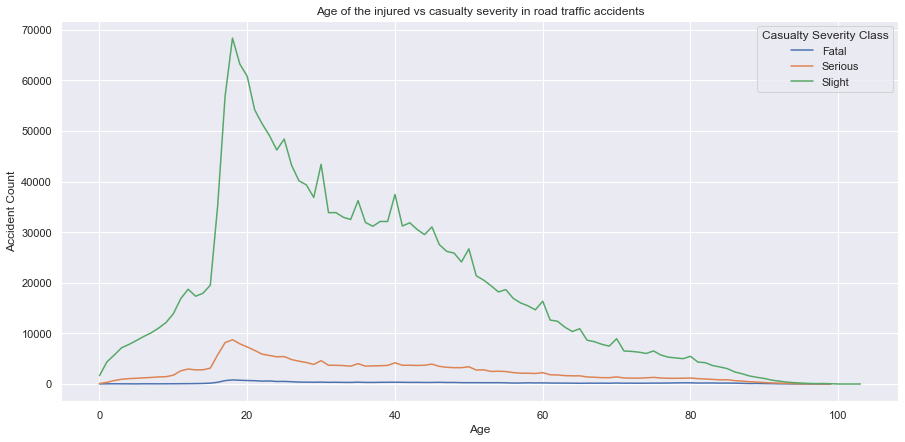

In [107]:
fig, ax = plt.subplots(figsize=(15,7))
casualties_data.groupby(['Age_of_Casualty', "Casualty_Severity"]).count()["Casualty_Class"].unstack().plot(ax=ax)
ax.set_xlabel('Age')
ax.set_ylabel('Accident Count')
ax.legend(["Fatal", "Serious", "Slight"], title = "Casualty Severity Class")
ax.set_title('Age of the injured vs casualty severity in road traffic accidents')

## Creating a new dataset
### Using the index column and the accident severity column from the first dataset (Traffic Data) and the vehicle age column from the second dataset (Vehicle Data) ###
It might be interesting to compare the vehicle age to the degree of accident severity. To do this, we are going to create a separate dataset with the columns we would like to have. Pandas will merge the columns in question by cross referencing the accident index column.

In [108]:
df1 = traffic_data[['Accident_Index', 'Accident_Severity']].copy(deep=True)
df1.shape

(1638055, 2)

In [109]:
df2 = vehicles_data_full[['Accident_Index', 'Age_of_Vehicle']].copy(deep=True)
df2.shape

(3004425, 2)

In [110]:
df3 = pd.merge(df1, df2)
df3.shape

(2999929, 3)

In [111]:
# df3.isnull().sum()

In [112]:
df3.dropna(subset = ["Age_of_Vehicle"], inplace = True)

Now we can inspect the resulting dataset. We will filter out the "-1" values (i.e. the missing data), and we will check for anything unusual.

In [113]:
display(df3.head())

df3.groupby(['Accident_Severity']).mean()

,Accident_Index,Accident_Severity,Age_of_Vehicle
1,200501BS00002,3,3.0
2,200501BS00003,3,5.0
3,200501BS00003,3,6.0
4,200501BS00004,3,4.0
5,200501BS00005,3,10.0


,Age_of_Vehicle
Accident_Severity,
1,7.300396
2,7.387577
3,7.218668


In [114]:
df3.groupby(['Accident_Severity']).min()

,Accident_Index,Age_of_Vehicle
Accident_Severity,,
1,200501RY10515,1.0
2,200501BS00019,1.0
3,200501BS00002,1.0


In [115]:
df3['Age_of_Vehicle'].nunique()
# There are 94 distinct vehicle ages

94

In [116]:
df3.groupby(['Accident_Severity']).max()

,Accident_Index,Age_of_Vehicle
Accident_Severity,,
1,2014984134914,72.0
2,2014984138414,111.0
3,2014984139614,100.0


In [117]:
s1 = df3[df3['Accident_Severity'] == 1]
s2 = df3[df3['Accident_Severity'] == 2]
s3 = df3[df3['Accident_Severity'] == 3]

# display(s1.head(5))
# display(s2.head(5))
# display(s3.head(5))

### Plotting Vehicle Age vs Accident Severity

Age_of_Vehicle
1.0    2436
2.0    2454
3.0    2346
4.0    2344
5.0    2283
dtype: int64

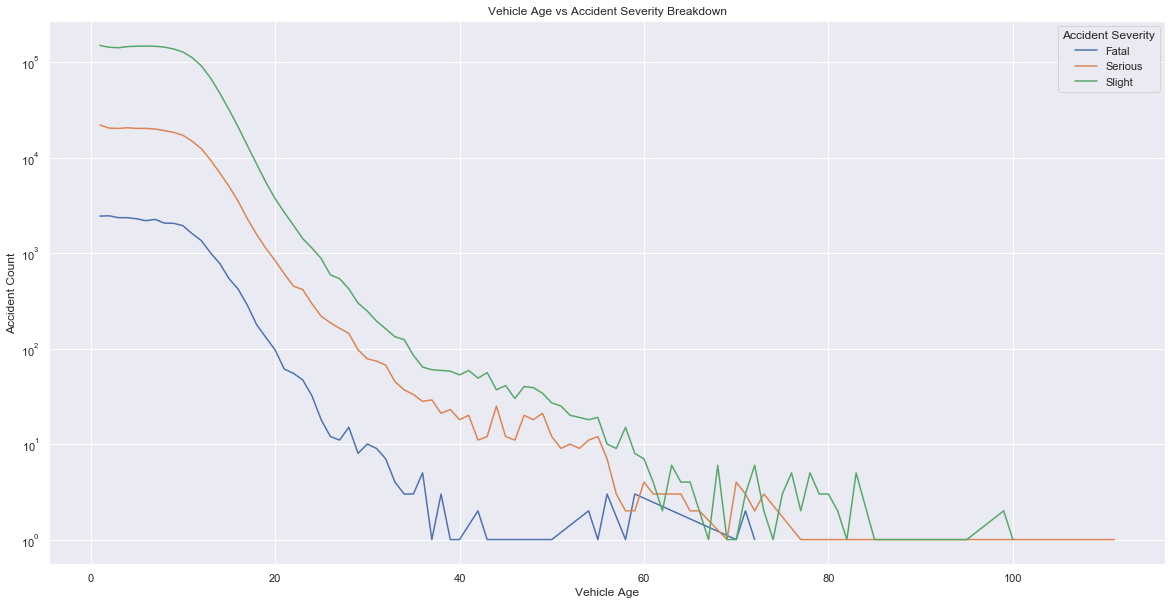

In [118]:
dataSev = s1['Accident_Severity'].head(55)
dataAge = s1['Age_of_Vehicle'].head(55)

# display(dataSev.head())
# display(dataAge.head())

data = s1.groupby('Age_of_Vehicle').size()
data2 = s2.groupby('Age_of_Vehicle').size()
data3 = s3.groupby('Age_of_Vehicle').size()

display(data.head())

plt.figure(figsize=(20,10))
# In this case, it's better to use a logarithmic scale:
plt.yscale('log')

plt.plot(data)
plt.plot(data2)
plt.plot(data3)
plt.title("Vehicle Age vs Accident Severity Breakdown")
plt.xlabel("Vehicle Age")
plt.ylabel("Accident Count")
plt.legend(['Fatal', 'Serious', 'Slight'], title="Accident Severity")

plt.show()

### Conclusion ###
In a nutshell, in addition to rejecting the null hypothesis (that there is no correlation between road conditions and accident severity), we were able to analyze a total of three datasets and gain insight about numerous significant variables affecting road traffic casualties.<br>
Some key observations include: a gradual decline of the total number of accidents over the past ten years; a prevalence of young people being injured most often (fortunately, in accidents of slight severity), as well as new cars getting involved in accidents much more frequently than all other categories; and considerably fewer accidents taking place in Scotland than the rest of the UK.

Sources:
- https://data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data

- https://jakevdp.github.io/PythonDataScienceHandbook/03.04-missing-values.html

- To Impute or not Impute: That’s the Question (Paper Methodological Advice) - Lodder, P. (Paul), University of Amsterdam

- [Tutorial: Pearson's Chi-square Test for Independence](https://www.ling.upenn.edu/~clight/chisquared.htm)

- https://www.ibm.com/cloud/blog/ibm-data-catalog-data-scientists-productivity